In [1]:
import geemap
import pandas as pd
import numpy as np
import pdb
from IPython.display import display
import ee
import os

#Group by class - then binary classification of class vs everything else

In [2]:
#Load from csv:
ulti_log = pd.read_csv('~F:/Iowa BMP/mosaic_elevation.csv') #mosaic_update3 = largest file without elevation

def bmp_classify(row):
    if row['PRACTICE'] == 'Farmland':
        return 'Non_BMP'
    return 'BMP'

def grassed_classify(row):
    if row['PRACTICE'] == 'Grassed Waterway':
        return 'Grassed'
    return 'Not_grassed'

ulti_log['BMP status'] = ulti_log.apply(bmp_classify, axis = 1)
ulti_log['Grassed status'] = ulti_log.apply(grassed_classify, axis = 1)

ulti_log

C:\Users\arj26323\AppData\Local\Temp\ipykernel_6032\300727005.py:2: DtypeWarning: Columns (5,8,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  ulti_log = pd.read_csv('~F:/Iowa BMP/mosaic_elevation.csv') #mosaic_update3 = largest file without elevation


,index,HUC_12,NRCS_CODE,PRACTICE,Present2_1,CREATOR_NA,Present80s,SHAPE_Area,LAST_EDIT_,Merge,...,N,Shape_Leng,ORIG_FID,Shape_Area,BUFF_DIST,CID,ndvi,ndwi,BMP status,Grassed status
0,0,7.080201e+10,332.0,Contour Buffer Strips,1.0,MP,0.0,186501.155605,NaN,NaN,...,160,NaN,NaN,NaN,NaN,NaN,0.367521,-0.300813,BMP,Not_grassed
1,1,7.080201e+10,332.0,Contour Buffer Strips,1.0,MP,0.0,186501.155605,NaN,NaN,...,127,NaN,NaN,NaN,NaN,NaN,0.322917,-0.251232,BMP,Not_grassed
2,2,7.080201e+10,332.0,Contour Buffer Strips,1.0,MP,0.0,186501.155605,NaN,NaN,...,127,NaN,NaN,NaN,NaN,NaN,0.322917,-0.251232,BMP,Not_grassed
3,3,7.080201e+10,332.0,Contour Buffer Strips,1.0,MP,0.0,186501.155605,NaN,NaN,...,135,NaN,NaN,NaN,NaN,NaN,0.310680,-0.250000,BMP,Not_grassed
4,4,7.080201e+10,332.0,Contour Buffer Strips,1.0,MP,0.0,186501.155605,NaN,NaN,...,148,NaN,NaN,NaN,NaN,NaN,0.333333,-0.254237,BMP,Not_grassed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899242,4995,NaN,NaN,Farmland,NaN,NaN,NaN,NaN,NaN,NaN,...,134,0.066038,100.0,0.000337,1000.0,0.0,0.229358,-0.089431,Non_BMP,Not_grassed
899243,4996,NaN,NaN,Farmland,NaN,NaN,NaN,NaN,NaN,NaN,...,134,0.066038,100.0,0.000337,1000.0,0.0,0.229358,-0.089431,Non_BMP,Not_grassed
899244,4997,NaN,NaN,Farmland,NaN,NaN,NaN,NaN,NaN,NaN,...,149,0.066038,100.0,0.000337,1000.0,0.0,0.201613,-0.095588,Non_BMP,Not_grassed
899245,4998,NaN,NaN,Farmland,NaN,NaN,NaN,NaN,NaN,NaN,...,130,0.066038,100.0,0.000337,1000.0,0.0,0.176471,-0.074380,Non_BMP,Not_grassed


In [3]:
ulti_log['Grassed status'].value_counts()

Grassed status
Not_grassed    525086
Grassed        374161
Name: count, dtype: int64

In [4]:
# Get the labeled training data for each band
red_train = ulti_log['R']
blue_train = ulti_log['B'] ##WHY DOES THIS WORK FOR MOSAIC BUT NOT FOR NON MOSAIC
green_train = ulti_log['G']
nir_train = ulti_log['N']
ndwi_train = ulti_log['ndvi']
ndvi_train = ulti_log['ndwi']

elev_train = ulti_log['elevation']

xargs = np.column_stack((blue_train, green_train, red_train, nir_train, ndvi_train, ndwi_train, elev_train)) 
##ORDER OF XARGS MATTERS

## Get the labeled value
# yargs = ulti_log['PRACTICE']
yargs = ulti_log['BMP status'] #Binary - either BMP or not

seed = 3

# Split to training and test data
from sklearn.model_selection import train_test_split
xargs_train, xargs_test, yargs_train, yargs_test = train_test_split(xargs, yargs, test_size=0.2, random_state=seed)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

'''
##LOOK INTO THIS: 
https://scikit-learn.org/stable/modules/generated/sklearn.
model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold
'''
class_weights = {'BMP': 0.2, 'Non_BMP': 0.8}  # Adjust the weights as needed

#Random forest classification
pipe = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('forest', RandomForestClassifier(n_estimators = 300, min_samples_leaf=10, class_weight=class_weights, \
                                          random_state=seed))
    ]
)

pipe.fit(xargs_train, yargs_train) #Train
y_pred=pipe.predict(xargs_test) #Fit the testing data

In [6]:
#Model results
print(accuracy_score(yargs_test, y_pred))
print(confusion_matrix(yargs_test, y_pred))

0.9367973311092577
[[121415   9439]
 [  1928  47068]]


In [7]:
#Recall, precision, and F1 scores
from sklearn.metrics import classification_report
print(classification_report(yargs_test, y_pred))

              precision    recall  f1-score   support

         BMP       0.98      0.93      0.96    130854
     Non_BMP       0.83      0.96      0.89     48996

    accuracy                           0.94    179850
   macro avg       0.91      0.94      0.92    179850
weighted avg       0.94      0.94      0.94    179850



In [8]:
sum(confusion_matrix(yargs_test, y_pred)) #why are these numbers so #172231 total

array([123343,  56507], dtype=int64)

In [9]:
df = ulti_log.groupby('PRACTICE')['imagedate'].count() #'index' not present in farmland extraction

df

PRACTICE
Contour Buffer Strips                         75000
Farmland                                     245000
Grassed Waterway                             374161
Pond Dam                                      15909
Stripcropping                                 20000
Terrace                                      129100
Water and Sediment Control Basin (WASCOB)     40077
Name: imagedate, dtype: int64

In [11]:
#Rasterio load geotiffs

import rasterio
import gdal

im = rasterio.open("F:/Iowa BMP/Geotiffs/IA/Tests/ia_im.tif")

print('bands: ' + str(im.count))
print('height: ' + str(im.height))
print('width: ' + str(im.width))
print('crs: ' + str(im.crs))

from matplotlib import pyplot as plt
from rasterio.plot import show

plt.imshow(im.read(1), cmap='pink')
# show(im)

input_tiff_path = "F:/Iowa BMP/Geotiffs/IA/Tests/ia_im.tif"
with rasterio.open(input_tiff_path) as src:
    red_band = src.read(1)
    green_band = src.read(2)
    blue_band = src.read(3)
    nir_band = src.read(4)
    
    ndvi_band = src.read(5)
    
    ndwi_band = src.read(6)
    
    elev_band = src.read(7) ##NOTE POSITION OF BANDs

    
# im.descriptions = tuple(['Blue', 'Green', 'Red', 'NIR','NDVWI','NDVI','ELEVATION']) - is this order correct?

src

ImportError: DLL load failed while importing _base: The specified module could not be found.

In [35]:
'''
im band designations (NEED TO BE IN THIS ORDER, how the model was trained. CHECK FOR EVERY IMAGE): 
1: blue
2: green
3: red
4: nir
5: ndvi (added)
6: nd2i (added)
7: elevation (added)
'''

im_whole = np.column_stack( ##DOUBLE CHECK BAND ORDER
    (
        im.read(3).ravel(), ##Blue
        im.read(2).ravel(), ##Green
        im.read(1).ravel(), ##Red
        im.read(4).ravel(), ##NIR
        im.read(5).ravel(), ##NDVI
        im.read(6).ravel(), ##NDWI
        im.read(7).ravel()  ##ELEVATION
                           )
) 

classified_labels = pipe.predict(im_whole)
classified_labels_reshaped = classified_labels.reshape(im.read(1).shape)

##CAREFUL HERE
class_mapping = {
    'Non_BMP': 1,
    'BMP': 2, 
}

classified_labels_numeric = np.vectorize(class_mapping.get)(classified_labels_reshaped)

In [36]:
classified_labels_reshaped

array([['Not_grassed', 'Not_grassed', 'Not_grassed', ..., 'Not_grassed',
        'Not_grassed', 'Not_grassed'],
       ['Not_grassed', 'Not_grassed', 'Not_grassed', ..., 'Not_grassed',
        'Not_grassed', 'Not_grassed'],
       ['Not_grassed', 'Not_grassed', 'Not_grassed', ..., 'Not_grassed',
        'Not_grassed', 'Not_grassed'],
       ...,
       ['Not_grassed', 'Not_grassed', 'Not_grassed', ..., 'Grassed',
        'Grassed', 'Grassed'],
       ['Not_grassed', 'Not_grassed', 'Not_grassed', ..., 'Grassed',
        'Grassed', 'Grassed'],
       ['Not_grassed', 'Not_grassed', 'Not_grassed', ..., 'Grassed',
        'Grassed', 'Grassed']], dtype=object)

In [37]:
classified_labels_numeric

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2]])

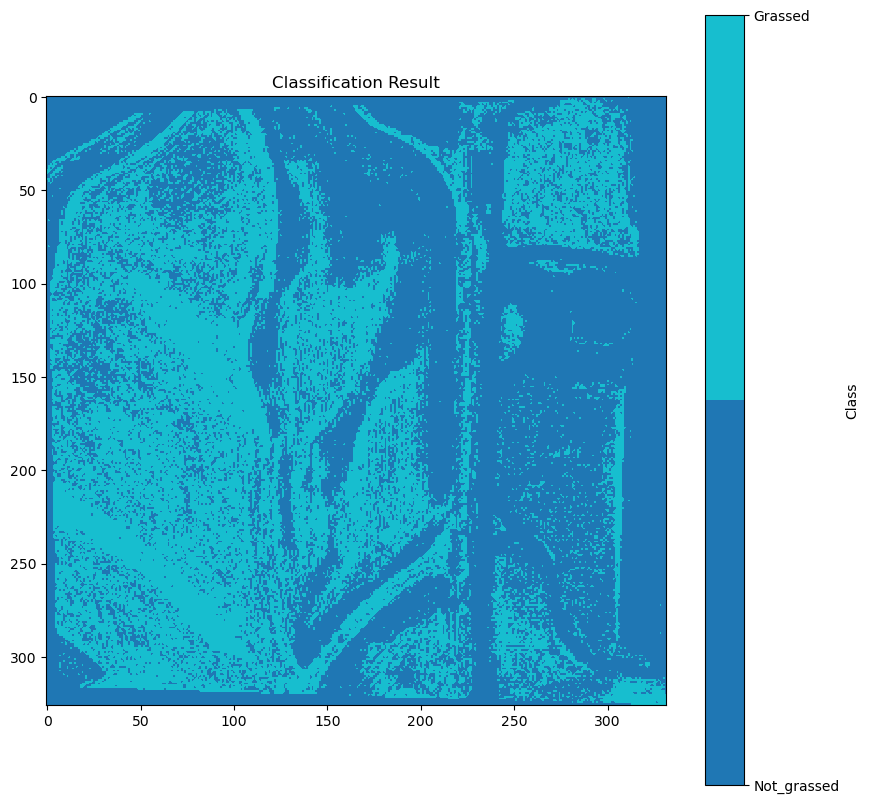

In [38]:
# Plot using tab10 colormap for discrete colors
tab10_custom = plt.get_cmap('tab10', 2)

# Plot using the custom colormap
plt.figure(figsize=(10, 10))
plt.imshow(classified_labels_numeric, cmap=tab10_custom, vmin=1, vmax=2)  # Specify vmin and vmax to ensure correct mapping
cbar = plt.colorbar(ticks=range(1, 3), label='Class')  # Specify ticks for discrete classes
cbar.ax.set_yticklabels(class_mapping.keys())  # Set custom tick labels for the colorbar
plt.title('Classification Result')
plt.show()

In [39]:
##Add NDVI and NDWI
# Open the existing GeoTIFF file in read mode
with rasterio.open("F:/Iowa BMP/Geotiffs/IA/Tests/m_4109451_nw_15_1_20100811.tif") as src:
    # Read the red and near-infrared bands
    red_band = src.read(1)  
    green_band = src.read(2)  
    blue_band = src.read(3)  
    nir_band = src.read(4)  

    # Calculate NDVI -- SOME INF VALUES, BELOW IS HOW TO DEAL WITH THEM?
    ndvi = np.where((nir_band + red_band) == 0, 0, (nir_band - red_band) / (nir_band + red_band))
    ndwi = np.where((green_band + nir_band) == 0, 0, (green_band - nir_band) / (green_band + nir_band))

    # Get metadata from the source file
    kwargs = src.meta

    # Update metadata for the new band
    kwargs.update(
        count=len(src.indexes) + 2,  # Increment band count
        dtype=rasterio.float32  # Specify data type (float32 for NDVI and NDWI)
    )

    # Open a new GeoTIFF file in write mode
    with rasterio.open("F:/Iowa BMP/Geotiffs/IA/Tests/X2_m_4109451_nw_15_1_20100811.tif", "w", **kwargs) as dst:
        # Write the existing bands to the new file
        for i in range(1, len(src.indexes) + 1):
            dst.write(src.read(i), i)

        # Write the NDVI band to the new file
        dst.write(ndvi.astype(rasterio.float32), len(src.indexes) + 1)

C:\Users\arj26323\AppData\Local\Temp\ipykernel_3164\4083756072.py:11: RuntimeWarning: divide by zero encountered in divide
  ndvi = np.where((nir_band + red_band) == 0, 0, (nir_band - red_band) / (nir_band + red_band))
C:\Users\arj26323\AppData\Local\Temp\ipykernel_3164\4083756072.py:12: RuntimeWarning: divide by zero encountered in divide
  ndwi = np.where((green_band + nir_band) == 0, 0, (green_band - nir_band) / (green_band + nir_band))
C:\Users\arj26323\AppData\Local\Temp\ipykernel_3164\4083756072.py:12: RuntimeWarning: invalid value encountered in divide
  ndwi = np.where((green_band + nir_band) == 0, 0, (green_band - nir_band) / (green_band + nir_band))


CPLE_AppDefinedError: Deleting F:/Iowa BMP/Geotiffs/IA/Tests/X2_m_4109451_nw_15_1_20100811.tif failed: Permission denied

bands: 6
height: 7663
width: 5997
crs: EPSG:26915


'\nim band designations (NEED TO BE IN THIS ORDER, how the model was trained. CHECK FOR EVERY IMAGE): \n1: blue\n2: green\n3: red\n4: nir\n5: ndvi (added)\n6: nd2i (added)\n7: NOT YET elevation (TO BE added)\n'

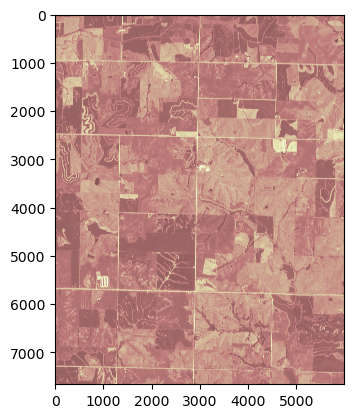

In [40]:
# im2 = rasterio.open("F:/Iowa BMP/Geotiffs/IA/Tests/bmp_naiponly.tif") #Add elevation isn't working
im2 = rasterio.open("F:/Iowa BMP/Geotiffs/IA/Tests/X2_m_4109451_nw_15_1_20100811.tif")

print('bands: ' + str(im2.count))
print('height: ' + str(im2.height))
print('width: ' + str(im2.width))
print('crs: ' + str(im2.crs))

plt.imshow(im2.read(1), cmap='pink')

'''
im band designations (NEED TO BE IN THIS ORDER, how the model was trained. CHECK FOR EVERY IMAGE): 
1: blue
2: green
3: red
4: nir
5: ndvi (added)
6: nd2i (added)
7: NOT YET elevation (TO BE added)
'''


In [41]:
im2_whole = np.column_stack( ##DOUBLE CHECK BANDS
    (
        im2.read(3).ravel(), ##Blue
        im2.read(2).ravel(), ##Green
        im2.read(1).ravel(), ##Red
        im2.read(4).ravel(), ##NIR
        im2.read(5).ravel(), ##NDVI
        im2.read(6).ravel(), ##NDWI
#         im2.read(7).ravel()  ##ELEVATION - NOT YET
                           )
) 

classified_labels2 = pipe.predict(im2_whole)
classified_labels_reshaped2 = classified_labels2.reshape(im2.read(1).shape)

##CAREFUL HERE
class_mapping = {
    'Non_BMP': 1,
    'BMP': 2, 
}

classified_labels_numeric2 = np.vectorize(class_mapping.get)(classified_labels_reshaped2)

In [42]:
classified_labels_reshaped2

array([['Not_grassed', 'Not_grassed', 'Not_grassed', ..., 'Not_grassed',
        'Not_grassed', 'Not_grassed'],
       ['Not_grassed', 'Not_grassed', 'Not_grassed', ..., 'Not_grassed',
        'Not_grassed', 'Not_grassed'],
       ['Not_grassed', 'Not_grassed', 'Not_grassed', ..., 'Not_grassed',
        'Not_grassed', 'Not_grassed'],
       ...,
       ['Not_grassed', 'Not_grassed', 'Not_grassed', ..., 'Grassed',
        'Not_grassed', 'Grassed'],
       ['Not_grassed', 'Not_grassed', 'Not_grassed', ..., 'Grassed',
        'Grassed', 'Grassed'],
       ['Not_grassed', 'Not_grassed', 'Not_grassed', ..., 'Grassed',
        'Not_grassed', 'Grassed']], dtype=object)

In [43]:
classified_labels_numeric2

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 2, 1, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 1, 2]])

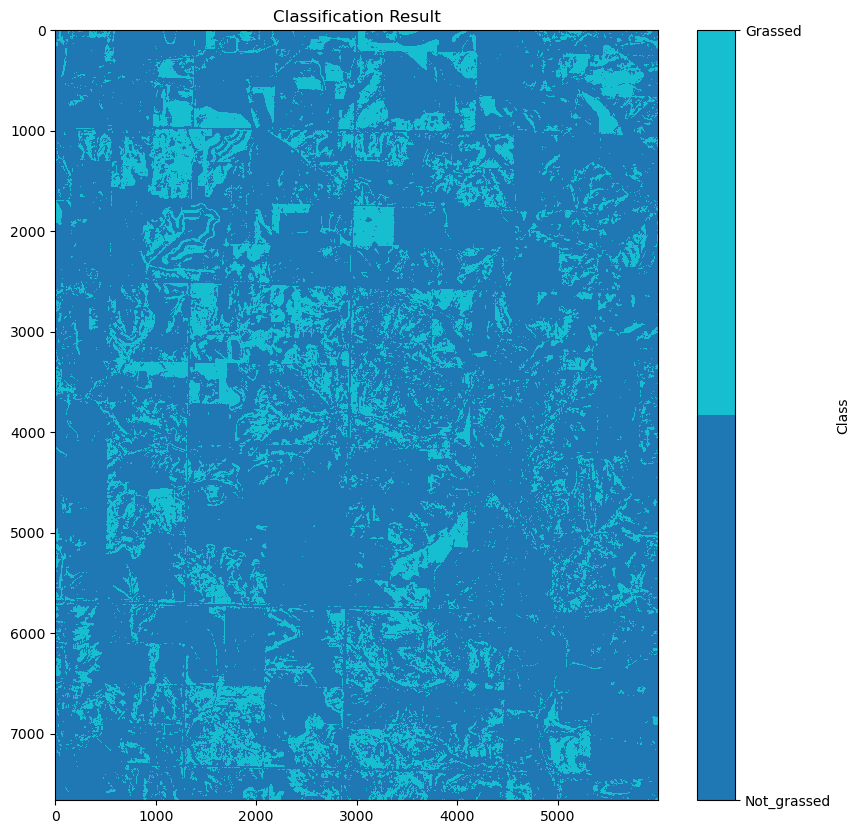

In [44]:
# Plot using tab10 colormap for discrete colors
tab10_custom = plt.get_cmap('tab10', 2)

# Plot using the custom colormap
plt.figure(figsize=(10, 10))
plt.imshow(classified_labels_numeric2, cmap=tab10_custom, vmin=1, vmax=2)  # Specify vmin and vmax to ensure correct mapping
cbar = plt.colorbar(ticks=range(1, 3), label='Class')  # Specify ticks for discrete classes
cbar.ax.set_yticklabels(class_mapping.keys())  # Set custom tick labels for the colorbar
plt.title('Classification Result')
plt.show()

In [ ]:
#Fin